In [1]:
import os, sys
from IPython.display import display, display_svg
from IPython.display import Math, Latex
from IPython.display import IFrame, HTML
import time
from datetime import datetime as dt
from pytz import timezone
import random, string

In [2]:
prefix = 'Parallel'
configdict = {
    'Serialpc': "DISABLE_JIT: 1",
    'Parallel': "DISABLE_JIT: 0\n"
                "NUM_THREADS: 2\n"
                "THREADING_LAYER: 'tbb'"
}


workdir = prefix +\
          dt.now(timezone('America/Bogota')).strftime('_%y%m%d-%H%M_') +\
          ''.join(random.sample(string.hexdigits, 4)
          )
os.mkdir(workdir)
os.chdir(workdir)
print('Working Directory:', os.getcwd(), sep='\n')
with open('.numba_config.yaml','w') as cf:
  cf.write(configdict[prefix])
  print('Numba Config:', configdict[prefix], sep='\n', end='\n\n')

Working Directory:
/content/Parallel_210811-2132_A7aF
Numba Config:
DISABLE_JIT: 0
NUM_THREADS: 2
THREADING_LAYER: 'tbb'



In [3]:
# https://stackoverflow.com/a/57883792
# https://stackoverflow.com/a/57113015
%%capture cap --no-stderr
%%bash
pip install tbb
pip install setuptools
# https://github.com/lycantropos/bentley_ottmann
# http://geomalgorithms.com/a09-_intersect-3.html#Shamos-Hoey-Algorithm
# http://euro.ecom.cmu.edu/people/faculty/mshamos/1976GeometricIntersection.pdf
pip install bentley_ottmann
# https://matplotlib-axes-aligner.readthedocs.io/en/latest/
pip install mpl-axes-aligner
pip install celluloid
pip install watermark
pip install tqdm --upgrade
# https://stackoverflow.com/a/57272111
pip install --upgrade plotly
wget -q https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
chmod +x /usr/local/bin/orca
apt-get install xvfb libgtk2.0-0 libgconf-2-4
pip install -U kaleido

In [4]:
with open('pip_installs.txt', 'w') as f:
    f.write(cap.stdout)
!pip freeze > requirements.txt

In [5]:
import pandas as pd
import numpy as np
from numba import njit, prange, config
from numba.np.extensions import cross2d

if config.DISABLE_JIT==1:
  cross2d = np.cross
  prange = range
  print('JIT DISABLED!')
else:
  print('JIT!')

JIT!


In [6]:
from IPython.display import set_matplotlib_formats

from numpy.linalg import norm
from numpy import random as rg
from scipy.interpolate import interp1d

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
set_matplotlib_formats('pdf', 'svg')
from matplotlib import style
#style.use('classic')


from collections import Counter
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib import colors as pltcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
# https://matplotlib-axes-aligner.readthedocs.io/en/latest/
from mpl_axes_aligner import align


from tqdm.auto import trange, tqdm
from pprint import pprint

from sympy import Point, Polygon
from ground.base import get_context
from bentley_ottmann.planar import contour_self_intersects
context  = get_context()
bPoint   = context.point_cls
bSegment = context.segment_cls
bContour = context.contour_cls

from celluloid import Camera
from matplotlib import animation, rc
from base64 import b64encode

In [7]:
#https://github.com/rasbt/watermark
%reload_ext watermark
%watermark -v -iv -m

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

mpl_axes_aligner: 1.1
pandas          : 1.1.5
matplotlib      : 3.2.2
sys             : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
numba           : 0.51.2
plotly          : 5.1.0
numpy           : 1.19.5
IPython         : 5.5.0



In [8]:
%%bash
lscpu
nvidia-smi

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.174
BogoMIPS:            4400.34
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [9]:
def showvideo(filename):
  #https://stackoverflow.com/a/57378660
  mp4 = open(filename, 'rb').read()
  data_url='data:video/mp4;base64,' + b64encode(mp4).decode()
  return display(HTML("""
  <video width=800 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
  ))

In [10]:
@njit(
  fastmath=True,
  error_model='numpy',
  )
def inner_angle(Model, i):
  k = len(Model)
  prev = Model[(i-1)%k]
  next = Model[(i+1)%k]
  here = Model[i%k]
  vetcs = prev-here, next-here
  #https://stackoverflow.com/a/14067171
  return -np.arctan2(
      cross2d(*vetcs),
      np.dot(*vetcs)
      )

@njit(
  fastmath=True,
  error_model='numpy',
  )
def grav(Model, XZ):
  k = len(Model)
  lenXZ = len(XZ)
  xietalist = np.empty(lenXZ)
  xietalist = [Model-XZ[i] for i in prange(lenXZ)]
  lenxieta = len(xietalist)
  grav = np.empty(lenxieta)
  for j in prange(lenxieta):
    xi = xietalist[j].T[0]
    eta = xietalist[j].T[1]
    sum = 0
    for i in prange(k):
      A = (xi[i-1]*eta[i] - xi[i]*eta[i-1])/\
          ((xi[i]-xi[i-1])**2 + (eta[i]-eta[i-1])**2)
      B1 = 0.5*(eta[i] - eta[i-1])*\
           np.log((xi[i]**2 + eta[i]**2)/\
          (xi[i-1]**2 + eta[i-1]**2))
      B2 = (xi[i] - xi[i-1])*\
           (np.arctan(xi[i]/eta[i])-\
           np.arctan(xi[i-1]/eta[i-1]))
      sum += A*(B1+B2)
    grav[j] = sum
  return grav

class Model(np.ndarray):
  def __new__(cls, input_array,*args,**kargs):
    return np.asarray(input_array).astype(np.float).view(cls)
  def __str__(self):
    return ','.join(map(str,self.flatten()))
  def area(self):
    # https://stackoverflow.com/a/30408825
    (x,z) = self.T
    return -0.5*(np.dot(x,np.roll(z,1))-np.dot(np.roll(x,1),z))
  def Cgeom(self):
    return np.array(np.mean(self,axis=0))
  def Cmass(self):
    # https://en.wikipedia.org/wiki/Centroid#Of_a_polygon
    k = self.__len__()
    A = self.area()
    (x,z) = self.T
    Cx = np.array(
        [(x[i%k] + x[(i+1)%k])*\
         (x[i%k]*z[(i+1)%k] - x[(i+1)%k]*z[i%k])\
         for i in range(k)]).sum()/A/6
    Cz = np.array(
        [(z[i%k] + z[(i+1)%k])*\
         (x[i%k]*z[(i+1)%k] - x[(i+1)%k]*z[i%k])\
         for i in range(k)]).sum()/A/6
    return np.array([Cx, Cz])
  def move(self, i, r, th):
    k = self.__len__()
    new = self.copy()
    new[i%k] = self[i%k] + r*np.array([np.cos(th), np.sin(th)])
    return new
  def birth(self, i, r, th):
    k = self.__len__()
    p = (self[i%k]+self[(i+1)%k])/2
    return np.insert(self, (i+1)%k, p, axis=0).move(i+1, r, th)
  def death(self, i):
    k = self.__len__()
    return np.delete(self, i%k, axis=0)
  def dvector(self, i):
    k = self.__len__()
    return np.array(
        (self[(i+1)%k] + self[(i-1)%k])/2-
        self[i%k]
        )
  def dradius(self,i):
    return norm(self.dvector(i))
  def dcat(self,i):
    k = self.__len__()
    return norm(self[(i+1)%k] - self[(i-1)%k])/2
  def bcat(self,i):
    k = self.__len__()
    return norm(self[(i+1)%k] - self[i%k])/2
  def vectors(self, i):
    k = self.__len__()
    prev = self[(i-1)%k]
    next = self[(i+1)%k]
    here = self[i%k]
    return np.array([prev-here, next-here])
  @njit(
    fastmath=True,
    error_model='numpy',
    )
  def angle(self, i):
    return inner_angle(self, i)
  def dists(self, i):
    mapvects = map(norm, self.vectors(i))
    return np.fromiter(mapvects, dtype=np.float)
  @njit(
    fastmath=True,
    error_model='numpy',
    )
  def gravitational(self, XZ):
    return grav(self, XZ)
  def notintersect(self):
  # https://github.com/lycantropos/bentley_ottmann 
  # Shamos-Huey algorithms 
   return not contour_self_intersects(
      bContour(list(map(lambda _: bPoint(*_), self))
      ))
   
def RegularModel(p, r, phi=np.pi/2, n=3):
  ths = phi+np.linspace(
      0, -2*np.pi, n,
      endpoint=False
      )
  return Model(
      [p + r*np.array([np.cos(th), np.sin(th)]) for th in ths])
   
def str2Model(str):
  return Model(eval(str)).reshape(-1, 2)

def Model_from_file(filename):
  with open(filename, 'r') as file:
    l = list(map(str2Model, file.readlines()))
    if len(l)==1:
      return l[0]
    else:
      return l
    file.close()

def Model_from_GeoGebra(filename):
  return Model(np.genfromtxt(filename))

def xz_iterp(XZ, start, stop, num=1000+1, kind='cubic'):
  xx = np.linspace(start, stop, num)
  zz = interp1d(*XZ.T, kind='cubic')(xx)
  return np.column_stack((xx, zz))

In [11]:
@njit(
    fastmath=True,
    error_model='numpy',
    )
def gaussian(x, mu, sigma):
  a = np.sqrt(2*np.pi)*sigma
  b = (x-mu)/sigma
  return np.exp(-0.5*b**2)/a

@njit(
    fastmath=True,
    error_model='numpy',
    )
def birth_death(newModel, oldModel, sigma_a, ps, r, ang=np.pi):
  oldk = len(oldModel)
  newk = len(newModel)
  b = ps[oldk-1, 1]
  d = ps[newk-1, 2]
  a = ang/gaussian(r, 0, sigma_a)
  return a*r*(d/b)/(newk/oldk)

@njit(
    fastmath=True,
    error_model='numpy',
    #parallel=True
    )
def Likelihood(TestModel, XZ, g, sigma=0.2):
  v=g-grav(TestModel, XZ)
  test=np.dot(v,v)/sigma**2
  return np.exp(-0.5*test)

@njit(
    fastmath=True,
    error_model='numpy',
    #parallel=True
    )
def Prior_density(TestModel,gamma=1.6):
  k = len(TestModel)
  wk = (k-2)*np.pi/k
  s = np.array([(inner_angle(TestModel,i)-wk)**2\
              for i in range(k)]).sum()
  test = k**gamma + s/k
  return np.exp(-test)

@njit(
    fastmath=True,
    error_model='numpy',
    #parallel=True
    )
def Relatives(newModel, oldModel, XZ, g, sigma=0.2, gamma=1.6):
  oldk  = len(oldModel)
  newk  = len(newModel)
  oldwk = (oldk-2)*np.pi/oldk
  newwk = (newk-2)*np.pi/newk
  oldv  = g-grav(oldModel,XZ)
  newv  = g-grav(newModel,XZ)
  olds  = np.array([(inner_angle(oldModel,i) - oldwk)**2\
                 for i in range(oldk)]).sum()
  news  = np.array([(inner_angle(newModel,i) - newwk)**2\
                 for i in range(newk)]).sum()
  oldPrior  = oldk**gamma+olds/oldk
  newPrior  = newk**gamma+news/newk
  Prior_rel = newPrior-oldPrior
  oldLikelihood  = np.dot(oldv,oldv)/sigma**2
  newLikelihood  = np.dot(newv,newv)/sigma**2
  Likelihood_Rel = newLikelihood-oldLikelihood
  return np.exp(-(
      Likelihood_Rel/2+
      Prior_rel
      ))

In [12]:
def acceptanceTest(oldModel, oldi, XZ, g, ps, sigma=0.2, gamma=1.6, ang=np.pi):
  k = len(oldModel)
  moves_arr = ['p', 'b', 'd']
  move = np.random.choice(moves_arr, p=ps[k-1])
  i = rg.choice(
        np.delete(np.arange(k), oldi%k)
        )
  if move==moves_arr[0]:
    sigma_a = min(*oldModel.dists(i))/4
    r  = rg.normal(0,sigma_a)
    th = rg.uniform(0,ang)
    newModel = oldModel.move(i,r,th)
    alpha = Relatives(
        newModel, oldModel, XZ, g,
        sigma=sigma, gamma=gamma
        )
  elif move==moves_arr[1]:
    sigma_a = oldModel.bcat(i)/4
    r  = rg.normal(0,sigma_a)
    th = rg.uniform(0,ang)
    newModel = oldModel.birth(i, r, th)
    alpha = Relatives(
        newModel, oldModel, XZ, g,
        sigma=sigma, gamma=gamma
        )*birth_death(newModel, oldModel, 
                      sigma_a, ps, r, ang=ang)
  elif move==moves_arr[2]:
    sigma_a = oldModel.dcat(i)/4
    r = oldModel.dradius(i)
    newModel = oldModel.death(i)
    alpha = Relatives(
        newModel, oldModel, XZ, g,
        sigma=sigma, gamma=gamma
        )/birth_death(oldModel,newModel,
                      sigma_a, ps, r, ang=ang)
  return (alpha, newModel, i, move)

In [13]:
%%file ../Gravity.tsv
0	12.5	35.6214
20	5.41927	43.8773
40	4.23178	56.006
60	12.3009	68.7457
80	6.7725	85.3607
100	3.30464	101.306
120	11.7193	100.308
140	8.18369	103.527
160	2.7117	101.321
180	10.8016	83.3477
200	9.54041	70.4755
220	2.5002	57.6322
240	9.6209	45.7897
260	10.7346	36.7938
280	2.68697	28.4563
300	8.27126	23.9835
320	11.6711	20.3333
340	3.25715	15.9083
360	6.86018	13.9207
380	12.2754	12.535
400	4.16531	10.0466
420	5.50007	8.8921
440	12.4992	8.40161
460	5.33911	6.92515
480	4.29928	6.10745
500	12.3248	5.97571

Writing ../Gravity.tsv


,divide,over,under,invalid
old_settings,warn,warn,ignore,warn
new_settings,raise,ignore,ignore,raise


Init Model:



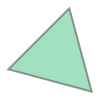

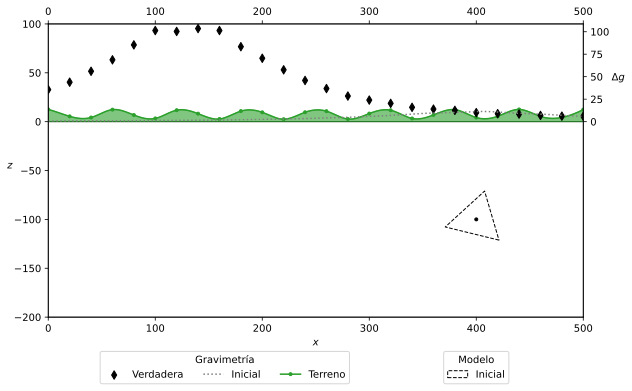

CPU times: user 4.2 s, sys: 1.21 s, total: 5.41 s
Wall time: 4.38 s


In [14]:
%%time

sigma = 0.2
gamma = 1.6
Maxk  = 20
ang   = np.pi

old_settings = np.geterr()
new_settings = {
    'divide':  'raise',
    'invalid': 'raise',
    'over':    'ignore',
    'under':   'ignore'
    }
settlist = ['old_settings','new_settings']
display(pd.DataFrame(
    list(map(eval, settlist)),
    index=settlist
    ))
"""
ignore: Take no action when the exception occurs.
warn: Print a RuntimeWarning (via the Python warnings module).
raise: Raise a FloatingPointError.
call: Call a function specified using the seterrcall function.
print: Print a warning directly to stdout.
log: Record error in a Log object specified by seterrcall.
"""

w = np.ones(Maxk)
b = np.ones(Maxk)
d = np.ones(Maxk)
b[-1] = 0
d[2] = 0
ps = np.array([list(p/sum(p)) for p in np.stack((w,b,d)).T])
ps[0:2][:] = np.zeros((2,3))

XZg = np.genfromtxt('../Gravity.tsv')
XZ = XZg[:,:2]
g  = XZg[:,-1]

XZmin = XZ
XZgrid = xz_iterp(
    XZ, 0, 500,
    num=1000+1,
    kind='cubic'
    )

InitModel = RegularModel(
    np.array([400, -100]),
    r=30,
    phi=-np.pi/4,
    n=3
    )

try:
  print('Init Model:\n')
  display_svg(Polygon(*map(Point, InitModel.copy())))
except:
  print('Error or Polygon has intersecting sides.')

Xi    = [XZgrid[:,0], InitModel.gravitational(XZgrid)]
Xgmin = [XZmin[:,0],  g]


fig, ax_z = plt.subplots(figsize=np.array([16,9])*3/5)
ax_z.tick_params(
    top=True,
    labeltop=True
    )
ax_g = ax_z.twinx()
ax_z.axhline(c='k', lw=1, zorder=0)

lineg = ax_g.scatter(
    *Xgmin,
    marker='d',
    color='k',
    label='Verdadera'
    )

ax_g.plot(
    *Xi,
    linestyle=':',
    color='gray'
    )
linei = Line2D(
  [0],[0],
  linestyle=':',
  color='gray',
  label='Inicial'
  )

ax_z.plot(
    *XZgrid.T,
    color='tab:green',
    label='_nolegend_'
)
ax_z.fill_between(
    *XZgrid.T,
    color='tab:green',
    alpha=3/5
)
ax_z.scatter(
    *XZmin.T,
    marker='.',
    color='tab:green',
    label='_nolegend_'
)
linez = Line2D(
  [0],[0],
  marker='.',
  color='tab:green',
  label='Terreno'
  )
Initpoly = patches.Polygon(
    InitModel,
    closed=True,
    Fill=False,
    linestyle='--',
    edgecolor='k',
    label='Inicial'
    )
ax_z.add_patch(Initpoly)

ax_z.scatter(
    *InitModel.Cmass(),
    marker='.',
    color='k',
    zorder=2
    )

ax_z.set_xlabel(r'$x$')
ax_z.set_ylabel(r'$z$', rotation=0)
ax_g.set_ylabel(r'$\quad\Delta{g}$', rotation=0, y=5/6)

ax_z.set_xlim(0, 500)
ax_z.set_ylim(ymin=-200)
ax_g.set_yticks(np.linspace(0, 100, 5))
align.yaxes(ax_z, 0, ax_g, 0, 2/3)

ax_g.legend(
    handles=[lineg, linei, linez],
    title='Gravimetría',
    bbox_to_anchor=(0.33, -.1),
    ncol=3,
    loc='upper center'
    )
ax_z.legend(
    handles=[Initpoly],
    title='Modelo',
    bbox_to_anchor=(0.8, -.1),
    ncol=2,
    loc='upper center'
    )
plt.savefig('InitPlot.pdf', bbox_inches='tight')
plt.show()

In [15]:
%%time

maxsteps = 12*10**3
miniters = 10

display(pd.DataFrame.from_dict(
    new_settings,
    orient='index',
    columns=['treatment']
    ).T)
print('Steps:')
start=dt.now()
with open('polygons.csv', 'w') as polygons,\
     open('itertimes.csv', 'w') as itertimes,\
     open('moves.csv', 'w') as moves,\
     open('errit.csv', 'w') as errit:
  pbar=tqdm(
      total=maxsteps,
      miniters=miniters,
      )
  loops=1
  steps=1
  errors=0
  oldtime=0
  polygons.write(str(InitModel.copy()) + '\n')
  moves.write('p\n')
  errit.write(f'{loops:d}\n')
  initk = len(InitModel)
  oldModel = InitModel
  oldi = rg.randint(initk)
  pbar.update(1)
  sys.stdout.write(
      f'\rErrors = {errors:07d}'+
      f'\tErrors/Loops = {errors/loops:.6f}'
      )
  while steps<maxsteps:
    loops += 1
    with np.errstate(**new_settings):
      try:
        alpha, newModel, newi, move = acceptanceTest(
            oldModel, oldi,
            XZ, g, ps,
            sigma=sigma,
            gamma=gamma,
            ang=ang
            )
        # Metropolis Condition and Shamos-Huey algorithm
        if rg.random()<min(1,alpha) and newModel.notintersect(): 
          polygons.write(str(newModel.copy()) + '\n')
          oldModel = newModel
          oldi     = newi
          moves.write(move + '\n')
          if steps%100==0:
            ittime = (dt.now()-start).total_seconds()
            itertimes.write(f'{ittime-oldtime:f}\n')
            oldtime = ittime
          steps += 1
          pbar.update(1)
      except FloatingPointError:
        errors += 1
        sys.stdout.write(
            f'\rErrors = {errors:07d}'+\
            f'\tErrors/Loops = {errors/loops:.6f}'
            )
        sys.stdout.flush()
        errit.write(f'{loops:d}\n')
  errit.write(f'{loops:d}\n')
  stop = dt.now()
  duration = (stop-start).total_seconds()
  itertimes.write(f'{duration-oldtime:f}\n')
  durationstr = dt.fromtimestamp(duration).strftime('%H:%M:%S.%f')
  polygons.close()
  itertimes.close()
  moves.close()
  errit.close()
pbar.close()
reject = loops  - steps
rejerr = reject - errors
print(
    f'\rErrors = {errors:07d}',
    f'\tErrors/Loops = {errors/loops:.6f}',
    end='\n')
print(
    f' Steps = {steps:07d}',
    f'\t Steps/Loops = {steps/loops:.6f}',
    end='\n')
print(f' Loops = {loops:07d}')
print(f'Reject = {reject:07d}')
print(f'Rejerr = {rejerr:07d}')
print(f'Tiempo:  {durationstr}')     

,divide,invalid,over,under
treatment,raise,raise,ignore,ignore


Steps:


  0%|          | 0/12000 [00:00<?, ?it/s]

Errors = 0000000 	Errors/Loops = 0.000000
 Steps = 0012000 	 Steps/Loops = 0.060833
 Loops = 0197260
Reject = 0185260
Rejerr = 0185260
Tiempo:  00:03:00.539209
CPU times: user 2min 58s, sys: 2.02 s, total: 3min 1s
Wall time: 3min


bigwalk:


  0%|          | 0/12000 [00:00<?, ?it/s]

biggeom:


  0%|          | 0/12000 [00:00<?, ?it/s]

walk:


  0%|          | 0/1000 [00:00<?, ?it/s]

geom:


  0%|          | 0/1000 [00:00<?, ?it/s]

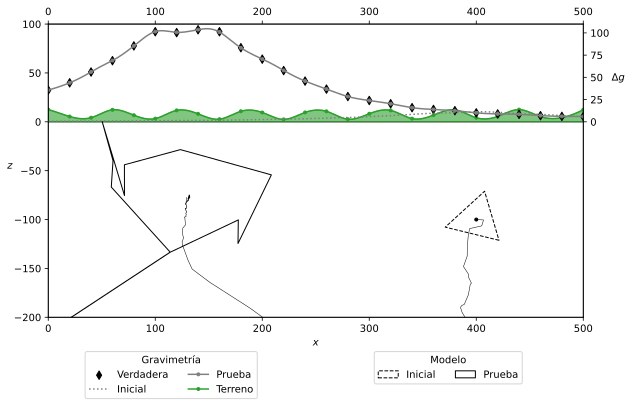

CPU times: user 5.99 s, sys: 1.43 s, total: 7.41 s
Wall time: 5.94 s


In [16]:
%%time

polygons = Model_from_file('polygons.csv')
lenp = len(polygons)
less = 1000
lesspolygons = [polygons[i] for i in range(0, lenp, int(lenp/less))]
InitModel = lesspolygons[0]
TestModel = lesspolygons[-1]
print('bigwalk:')
bigwalk = np.array([p.Cmass() for p in tqdm(polygons)])
print('biggeom:')
biggeom = np.array([p.Cgeom() for p in tqdm(polygons)])
print('walk:')
walk    = np.array([p.Cmass() for p in tqdm(lesspolygons)])
print('geom:')
geom    = np.array([p.Cgeom() for p in tqdm(lesspolygons)])


fig, ax_z = plt.subplots(figsize=np.array([16,9])*3/5)
ax_z.tick_params(
    top=True,
    labeltop=True
    )
ax_g = ax_z.twinx()
ax_z.axhline(c='k', lw=1, zorder=0)

Xy    = [XZgrid[:,0], lesspolygons[-1].gravitational(XZgrid)]
Xymin = [XZmin[:,0],  lesspolygons[-1].gravitational(XZmin) ]

lineg = ax_g.scatter(
    *Xgmin,
    marker='d',
    color='k',
    label='Verdadera'
    )

ax_g.plot(
    *Xi,
    linestyle=':',
    color='gray'
    )
linei = Line2D(
  [0],[0],
  linestyle=':',
  color='gray',
  label='Inicial'
  )

ax_g.plot(
    *Xy,
    color='gray'
    )
ax_g.scatter(
    *Xymin,
    marker='.',
    color='gray',
    label='_nolegend_'
    )
liney = Line2D(
  [0],[0],
  marker='.',
  color='gray',
  label='Prueba'
  )

ax_z.plot(
    *XZgrid.T,
    color='tab:green',
    label='_nolegend_'
)
ax_z.fill_between(
    *XZgrid.T,
    color='tab:green',
    alpha=3/5
)
ax_z.scatter(
    *XZmin.T,
    marker='.',
    color='tab:green',
    label='_nolegend_'
)
linez = Line2D(
  [0],[0],
  marker='.',
  color='tab:green',
  label='Terreno'
  )

Initpoly = patches.Polygon(
    lesspolygons[0],
    closed=True,
    Fill=False,
    linestyle='--',
    edgecolor='k',
    label='Inicial'
    )
ax_z.add_patch(Initpoly)

Testpoly = patches.Polygon(
    lesspolygons[-1],
    closed=True,
    Fill=False,
    edgecolor='k',
    label='Prueba'
    )
ax_z.add_patch(Testpoly)

ax_z.scatter(
    *lesspolygons[0].Cmass(),
    marker='.',
    color='k',
    zorder=2
    )
ax_z.plot(
    *walk.T,
    linewidth=0.5,
    color='k',
    )

ax_z.set_xlabel(r'$x$')
ax_z.set_ylabel(r'$z$', rotation=0)
ax_g.set_ylabel(r'$\quad\Delta{g}$', rotation=0, y=5/6)

ax_z.set_xlim(0, 500)
ax_z.set_ylim(ymin=-200)
ax_g.set_yticks(np.linspace(0, 100, 5))
align.yaxes(ax_z, 0, ax_g, 0, 2/3)


ax_g.legend(
    handles=[lineg, linei, liney, linez],
    title='Gravimetría',
    bbox_to_anchor=(.4, -.1),
    ncol=2,
    loc='upper right'
    )
ax_z.legend(
    handles=[Initpoly, Testpoly],
    title='Modelo',
    bbox_to_anchor=(.6, -.1),
    ncol=2,
    loc='upper left'
    )
plt.savefig('Plot.pdf', bbox_inches='tight')
plt.show()

In [17]:
%%time

fps = 30
print(f'Graficando cada fotograma, puede tardar un tiempo...')
fig, ax_z = plt.subplots(figsize=np.array([16,9])*3/5, dpi=300)
ax_z.tick_params(
    top=True,
    labeltop=True
    )
ax_g = ax_z.twinx()
camera=Camera(fig)
ax_z.tick_params(
    top=True,
    labeltop=True
    )
for i, TestModel in tqdm(
    enumerate(lesspolygons),
    total=len(lesspolygons),
    miniters=10
    ):
  ax_z.axhline(c='k', lw=1, zorder=0)
  
  Xy    = [XZgrid[:,0], TestModel.gravitational(XZgrid)]
  Xymin = [XZmin[:,0],  TestModel.gravitational(XZmin) ]

  lineg = ax_g.scatter(
      *Xgmin,
      marker='d',
      color='k',
      label='Verdadera'
      )

  ax_g.plot(
      *Xi,
      linestyle=':',
      color='gray'
      )
  linei = Line2D(
    [0],[0],
    linestyle=':',
    color='gray',
    label='Inicial'
    )

  ax_g.plot(
      *Xy,
      color='gray'
      )
  ax_g.scatter(
      *Xymin,
      marker='.',
      color='gray',
      label='_nolegend_'
      )
  liney = Line2D(
    [0],[0],
    marker='.',
    color='gray',
    label='Prueba'
    )

  ax_z.plot(
      *XZgrid.T,
      color='tab:green',
      label='_nolegend_'
  )
  ax_z.fill_between(
      *XZgrid.T,
      color='tab:green',
      alpha=3/5
  )
  ax_z.scatter(
      *XZmin.T,
      marker='.',
      color='tab:green',
      label='_nolegend_'
  )
  linez = Line2D(
    [0],[0],
    marker='.',
    color='tab:green',
    label='Terreno'
    )

  Initpoly = patches.Polygon(
      lesspolygons[0],
      closed=True,
      Fill=False,
      linestyle='--',
      edgecolor='k',
      label='Inicial'
      )
  ax_z.add_patch(Initpoly)

  Testpoly = patches.Polygon(
      TestModel,
      closed=True,
      Fill=False,
      edgecolor='k',
      label='Prueba'
      )
  ax_z.add_patch(Testpoly)

  ax_z.scatter(
      *lesspolygons[0].Cmass(),
      marker='.',
      color='k',
      zorder=2
      )
  ax_z.plot(
      *walk[:i].T,
      linewidth=0.5,
      color='k',
      )

  ax_z.set_xlabel(r'$x$')
  ax_z.set_ylabel(r'$z$', rotation=0)
  ax_g.set_ylabel(r'$\quad\Delta{g}$', rotation=0, y=5/6)

  ax_z.set_xlim(0, 500)
  ax_z.set_ylim(ymin=-200)
  ax_g.set_yticks(np.linspace(0, 100, 5))
  align.yaxes(ax_z, 0, ax_g, 0, 2/3)

  ax_g.legend(
      handles=[lineg, linei, liney, linez],
      title='Gravimetría',
      bbox_to_anchor=(.4, -.1),
      ncol=2,
      loc='upper right'
      )
  ax_z.legend(
      handles=[Initpoly, Testpoly],
      title='Modelo',
      bbox_to_anchor=(.6, -.1),
      ncol=2,
      loc='upper left'
      )
  plt.tight_layout(w_pad=0, h_pad=1)
  camera.snap()
plt.close()
animation=camera.animate(interval=less/fps, repeat=False)
#interval: Delay between frames in milliseconds. Defaults to 200.
filename='video.mp4'
start=dt.now()
print(f'Guardando el archivo {filename}, puede tardar un tiempo...')
pbar=tqdm(total=less)
animation.save(filename, progress_callback=\
               lambda i, n: pbar.update(1)
               )
pbar.close()
stop=dt.now()
videoduration=int((stop-start).total_seconds())
videodurationstr=dt.fromtimestamp(videoduration).strftime('%M:%S')
print(f'Archivo {filename} Guardado!\n Tiempo: {videodurationstr}')
showvideo(filename)

Graficando cada fotograma, puede tardar un tiempo...


  0%|          | 0/1000 [00:00<?, ?it/s]

Guardando el archivo video.mp4, puede tardar un tiempo...


  0%|          | 0/1000 [00:00<?, ?it/s]

Archivo video.mp4 Guardado!
 Tiempo: 13:10


CPU times: user 25min 53s, sys: 8min 38s, total: 34min 31s
Wall time: 25min 24s


In [18]:
!rm -f zfiles.zip
!7z a -bso0 ../{workdir}.zip *.* -x!*.zip
!7z l ../{workdir}.zip

  0M Scan             0%     33% 9 + video.mp4                   67% 9 + video.mp4                  
7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../             1 file, 2180611 bytes (2130 KiB)

Listing archive: ../Parallel_210811-2132_A7aF.zip

--
Path = ../Parallel_210811-2132_A7aF.zip
Type = zip
Physical Size = 2180611

   Date      Time    Attr         Size   Compressed  Name
------------------- ----- ------------ ------------  ------------------------
2021-08-12 02:33:17 .....        31136        24240  InitPlot.pdf
2021-08-12 02:36:23 .....        39693        32168  Plot.pdf
2021-08-12 02:36:19 .....            9            9  errit.csv
2021-08-12 02:36:19 ..... 